In [1]:
import pandas as pd
import numpy as np
import pyBigWig as pybw
import os
import h5py
import pyfaidx
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
font_path = "/users/atwang/fonts/Inter/Inter Variable/Inter.ttf"
prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

sns.set(font=prop.get_name())

In [3]:
params = {
    "CTCF": {
        "tobias_motif_id": "CTCF_MA0139.1_CTCF_MA0139.1_1",
        "chip_enc": "ENCSR000EGM",
        "atac_motif_id": "0_1",
        "dnase_motif_id": "0_1",
        "v2_motif_id": "pos_patterns.pattern_1"
    },
    "GATA": {
        "tobias_motif_id": "GATA3_GATA_1_GATA3_GATA_1",
        "chip_enc": "ENCSR257RKC",
        "atac_motif_id": "0_0",
        "dnase_motif_id": "0_0",
        "v2_motif_id": "pos_patterns.pattern_0"
    },
    "SP1": {
        "tobias_motif_id": "KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C",
        "chip_enc": "ENCSR372IML",
        "atac_motif_id": "0_2",
        "dnase_motif_id": "0_2",
        "v2_motif_id": "pos_patterns.pattern_2"
    },
    "YY1": {
        "tobias_motif_id": "TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A",
        "chip_enc": "ENCSR372IML",
        "atac_motif_id": "0_13",
        "dnase_motif_id": "0_13",
        "v2_motif_id": "pos_patterns.pattern_13"
    },
}


# #tobias_motif_id ="GATA3_GATA_1_GATA3_GATA_1"
# #tobias_motif_id = "TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A"
# tobias_motif_id = "CTCF_MA0139.1_CTCF_MA0139.1_1"
# #tobias_motif_id="KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C"
# #chip_enc = "ENCSR257RKC"
# #chip_enc = "ENCSR000EWF"
# chip_enc = "ENCSR000EGM"
# #chip_enc = "ENCSR372IML"
# hit_call_bed_atac = "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_ATAC/"
# #atac_motif_id= "0_15"
# #atac_motif_id= "0_0"
# atac_motif_id="0_1"
# #atac_motif_id= "0_2"
hit_call_bed_dnase= "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/"
# #dnase_motif_id= "0_15"
# #dnase_motif_id= "0_0"
# dnase_motif_id= "0_1"
# #dnase_motif_id= "0_2"
# # use arguments to fill paths

finemo_proj_hits_path = "/oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/v10_proj_a_0.8_c_0.0005/hits_unique.tsv"
finemo_hyp_hits_path = "/oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/v10_hyp_a_0.8_c_0.0005/hits_unique.tsv"


# output_dir = "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/viveks/og_version_filter_modisco_rank_resolve_benchmark/"
output_dir = "/oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/"


motif_hits_path_tobias_template="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/{tobias_motif_id}/beds/{tobias_motif_id}_K562_bound.bed"
chip_seq_bw_path_template="/oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/{chip_enc}/counts_scores.bw"
chip_seq_bed_path_template="/oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/{chip_enc}/peaks_valid_scores.bed"

# atac_hits_path=os.path.join(hit_call_bed_atac,"temp/final.bed")
dnase_hits_path=os.path.join(hit_call_bed_dnase,"auxiliary/final.bed")

# observed_atac = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw"
observed_dnase = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/data/K562_unstranded.bw"

genome_fasta = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"

tfmodisco_atac="/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/ATAC/K562/modiscolite_crop_500_1M_seqs/modisco_results_allChroms_counts.hdf5"
tfmodisco_dnase="/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/modiscolite_crop_500_1M_seqs/modisco_results_allChroms_counts.hdf5"


In [4]:
finemo_proj_hits_bed = os.path.join(output_dir, "finemo_hits_proj.bed")
finemo_hyp_hits_bed = os.path.join(output_dir, "finemo_hits_hyp.bed")
os.makedirs(output_dir, exist_ok=True)

In [5]:
os.system(fr"""
cat "{finemo_proj_hits_path}" | awk '{{print $1 "\t" $2 "\t" $3 "\t" $6 "\t" $10 "\t" $7 "\t" $8 "\t" $9 }}' | tail -n +2 > "{finemo_proj_hits_bed}"
""")
os.system(fr"""
cat "{finemo_hyp_hits_path}" | awk '{{print $1 "\t" $2 "\t" $3 "\t" $6 "\t" $10 "\t" $7 "\t" $8 "\t" $9 }}' | tail -n +2 > "{finemo_hyp_hits_bed}"
""")

0

In [6]:
def find_hits_in_peaks(input_hits, chip_bed, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    # output_path = os.path.join(output_dir, output_path)
    #print(output_dir)
    command = []
    command += ["bedtools"]
    command += ["intersect"]
    command += ["-a"]
    command += [input_hits]
    command += ["-b"]
    command += [chip_bed]
    command += ["-wa"]
    command += ["|"]
    command += ["sort"]
    command += ["|"]
    command += ["uniq"]
    command += [">"]
    command += [output_path]
    
    print(" ".join(command))
    os.system(" ".join(command))
    
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))
 
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    
    def softmax(x, temp=100):
        norm_x = x - np.mean(x,axis=1, keepdims=True)
        return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

    def trim_motif_new(cwm, motif, trim_threshold=0.3, max_motif_width=None):
        """
        Given the PFM and motif (both L x 4 arrays) (the motif could be the
        PFM itself), trims `motif` by cutting off flanks of low information
        content in `pfm`. `min_ic` is the minimum required information
        content. If specified this trimmed motif will be extended on either
        side by `pad` bases.
        If no base passes the `min_ic` threshold, then no trimming is done.
        """

        score = np.sum(np.abs(cwm), axis=1)
        trim_thresh = np.max(score) * trim_threshold  # Cut off anything less than 30% of max score
        pass_inds = np.where(score >= trim_thresh)[0]
        trimmed = motif[np.min(pass_inds): np.max(pass_inds) + 1]

        return trimmed
    
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    pfm = trim_motif_new(cwm, cwm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = softmax(pfm)
    return pfms


In [7]:
def fetch_footprint_scores_for_tobias(motif_hits_path_tobias, chip_bpnet, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key",  "score", "strand", "pchr", "pstart", "pend", "imp_frac_score"]
    
    hit_table_tobias = pd.read_csv(motif_hits_path_tobias, sep="\t", header=None, names=names)
    #print(hit_table_tobias)
    prof_coords = hit_table_tobias[["chrom", "start", "end"]].values
    strands = hit_table_tobias["strand"].values
    
    footprint_scores = []
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*one_hot[0]),axis=1)))
        footprint_scores.append(val_bp)
            
    hit_table_tobias["footprint"]  = footprint_scores
    
    return hit_table_tobias


In [8]:
def fetch_v1_scores_for_chrombpnet(motif_hits_path, keyd, chip_bpnet, observed_data, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key", "strand", "match_score", "imp_frac_score", "cwm_scores", "pvalue", "qvalue", "clust"]
    hit_table = pd.read_csv(motif_hits_path, sep="\t", header=None, names=names)
    
    print(hit_table.head())
    hit_table = hit_table[hit_table["key"].isin(keyd)]
    print(hit_table.shape)
                        
    prof_coords = hit_table[["chrom", "start", "end"]].values
    strands = hit_table["strand"].values
    
    footprint_scores = []
    observed_counts = []
              
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*one_hot[0]),axis=1)))
              
        obs_d = np.mean(np.nan_to_num(observed_data.values(chrom,start,end)))

        observed_counts.append(obs_d)
        footprint_scores.append(val_bp)
            
    hit_table["footprint"]  = footprint_scores
    hit_table["counts"]  = observed_counts
  
    return hit_table


In [9]:
def fetch_v2_scores_for_chrombpnet(motif_hits_path, keyd, chip_bpnet, observed_data, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key", "strand", "coefficient", "correlation", "importance"]
    hit_table = pd.read_csv(motif_hits_path, sep="\t", header=None, names=names)
    
    print(hit_table.head())
    hit_table = hit_table[hit_table["key"].isin(keyd)]
    print(hit_table.shape)
                        
    prof_coords = hit_table[["chrom", "start", "end"]].values
    strands = hit_table["strand"].values
    
    footprint_scores = []
    observed_counts = []
              
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*one_hot[0]),axis=1)))
              
        obs_d = np.mean(np.nan_to_num(observed_data.values(chrom,start,end)))

        observed_counts.append(obs_d)
        footprint_scores.append(val_bp)
            
    hit_table["footprint"]  = footprint_scores
    hit_table["counts"]  = observed_counts
  
    return hit_table


In [10]:


def plot_scores(counts_dnase_2_proj, counts_dnase_2_hyp, counts_dnase, tobias_atac):

    fig, ax = plt.subplots(nrows=1, ncols=1)

    sort_col="coefficient"
    motif_hit_table_sorted = counts_dnase_2_proj.sort_values(sort_col, ascending=False)
    footprint_scores = motif_hit_table_sorted["footprint"]

    ax.plot(
        np.arange(len(footprint_scores)),
        np.cumsum(footprint_scores),
        label="v2 Projected"
    )


    # sort_col="correlation"
    # motif_hit_table_sorted = counts_dnase_2_proj.sort_values(sort_col, ascending=False)
    # footprint_scores = motif_hit_table_sorted["footprint"]

    # ax.plot(
    #     np.arange(len(footprint_scores)),
    #     np.cumsum(footprint_scores),
    #     label="v2 Projected (Correlation)"
    # )


    sort_col="coefficient"
    motif_hit_table_sorted = counts_dnase_2_hyp.sort_values(sort_col, ascending=False)
    footprint_scores = motif_hit_table_sorted["footprint"]

    ax.plot(
        np.arange(len(footprint_scores)),
        np.cumsum(footprint_scores),
        label="v2 Hypothetical"
    )


    # sort_col="correlation"
    # motif_hit_table_sorted = counts_dnase_2_hyp.sort_values(sort_col, ascending=False)
    # footprint_scores = motif_hit_table_sorted["footprint"]

    # ax.plot(
    #     np.arange(len(footprint_scores)),
    #     np.cumsum(footprint_scores),
    #     label="v2 Hypothetical (Correlation)"
    # )


    sort_col="cwm_scores"
    motif_hit_table_sorted = counts_dnase.sort_values(sort_col, ascending=False)
    footprint_scores = motif_hit_table_sorted["footprint"]

    ax.plot(
        np.arange(len(footprint_scores)),
        np.cumsum(footprint_scores),
        label="v1"
    )


    sort_col="imp_frac_score"
    motif_hit_table_sorted_tobias = tobias_atac.sort_values(sort_col, ascending=False)
    footprint_scores_tobias = motif_hit_table_sorted_tobias["footprint"]

    ax.plot(
        np.arange(len(footprint_scores_tobias)),
        np.cumsum(footprint_scores_tobias),
        label="ATAC Tobias"
    )

    plt.legend()

    plt.ylabel("Cumulative ChIP-seq importance")
    plt.xlabel("Hit rank")
    #plt.savefig(os.path.join(output_dir,output_path),format='pdf',)

In [11]:
pfm_atac = import_tfmodisco_motifs(tfmodisco_atac)
pfm_dnase = import_tfmodisco_motifs(tfmodisco_dnase)
# chip_seq_bw = pybw.open(chip_seq_bw_path)
# atac_bw =  pybw.open(observed_atac)
dnase_bw =  pybw.open(observed_dnase)
genome = pyfaidx.Fasta(genome_fasta)

In [12]:
tf = "CTCF"


params_tf = params[tf]

motif_hits_path_tobias =  motif_hits_path_tobias_template.format(tobias_motif_id=params_tf["tobias_motif_id"])
chip_seq_bw_path = chip_seq_bw_path_template.format(chip_enc=params_tf["chip_enc"])
chip_seq_bed_path = chip_seq_bed_path_template.format(chip_enc=params_tf["chip_enc"])

chip_seq_bw = pybw.open(chip_seq_bw_path)

tobias_motif_id = params_tf["tobias_motif_id"]
chip_enc = params_tf["chip_enc"]
dnase_motif_id = params_tf["dnase_motif_id"]
atac_motif_id = params_tf["atac_motif_id"]
v2_motif_id = params_tf["v2_motif_id"]


tobias_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+tobias_motif_id),"tobias_hits_in_peaks.bed")
find_hits_in_peaks(motif_hits_path_tobias, chip_seq_bed_path, tobias_hits_peaks)

# find_hits_in_peaks(atac_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+atac_motif_id), "atac_hits_in_peaks.bed")
# atac_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+atac_motif_id),"atac_hits_in_peaks.bed")

dnase_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"dnase_hits_in_peaks.bed")
find_hits_in_peaks(dnase_hits_path, chip_seq_bed_path, dnase_hits_peaks)

finemo_proj_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_proj_hits_in_peaks.bed")
find_hits_in_peaks(finemo_proj_hits_bed, chip_seq_bed_path, finemo_proj_hits_peaks)

finemo_hyp_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_hyp_hits_in_peaks.bed")
find_hits_in_peaks(finemo_hyp_hits_bed, chip_seq_bed_path, finemo_hyp_hits_peaks)

tobias_atac = fetch_footprint_scores_for_tobias(tobias_hits_peaks, chip_seq_bw, pfm_atac[atac_motif_id], genome)
tobias_atac.shape
#counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [atac_motif_id], chip_seq_bw, atac_bw, pfm_atac[atac_motif_id], genome)
# counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [dnase_motif_id], chip_seq_bw, atac_bw, pfm_dnase[dnase_motif_id], genome)


#counts_dnase = fetch_footprint_scores_for_chrombpnet(dnase_hits_path, [atac_motif_id], chip_seq_bw, dnase_bw, pfm_atac[atac_motif_id], genome)
counts_dnase = fetch_v1_scores_for_chrombpnet(dnase_hits_peaks, [dnase_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase_proj_2 = fetch_v2_scores_for_chrombpnet(finemo_proj_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)
counts_dnase_hyp_2 = fetch_v2_scores_for_chrombpnet(finemo_hyp_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)


bedtools intersect -a /mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/CTCF_MA0139.1_CTCF_MA0139.1_1/beds/CTCF_MA0139.1_CTCF_MA0139.1_1_K562_bound.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR000EGM/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR000EGM_CTCF_MA0139.1_CTCF_MA0139.1_1/tobias_hits_in_peaks.bed


bedtools intersect -a /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/auxiliary/final.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR000EGM/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR000EGM_0_1/dnase_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_proj.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR000EGM/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR000EGM_0_1/finemo_proj_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_hyp.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR000EGM/peaks_

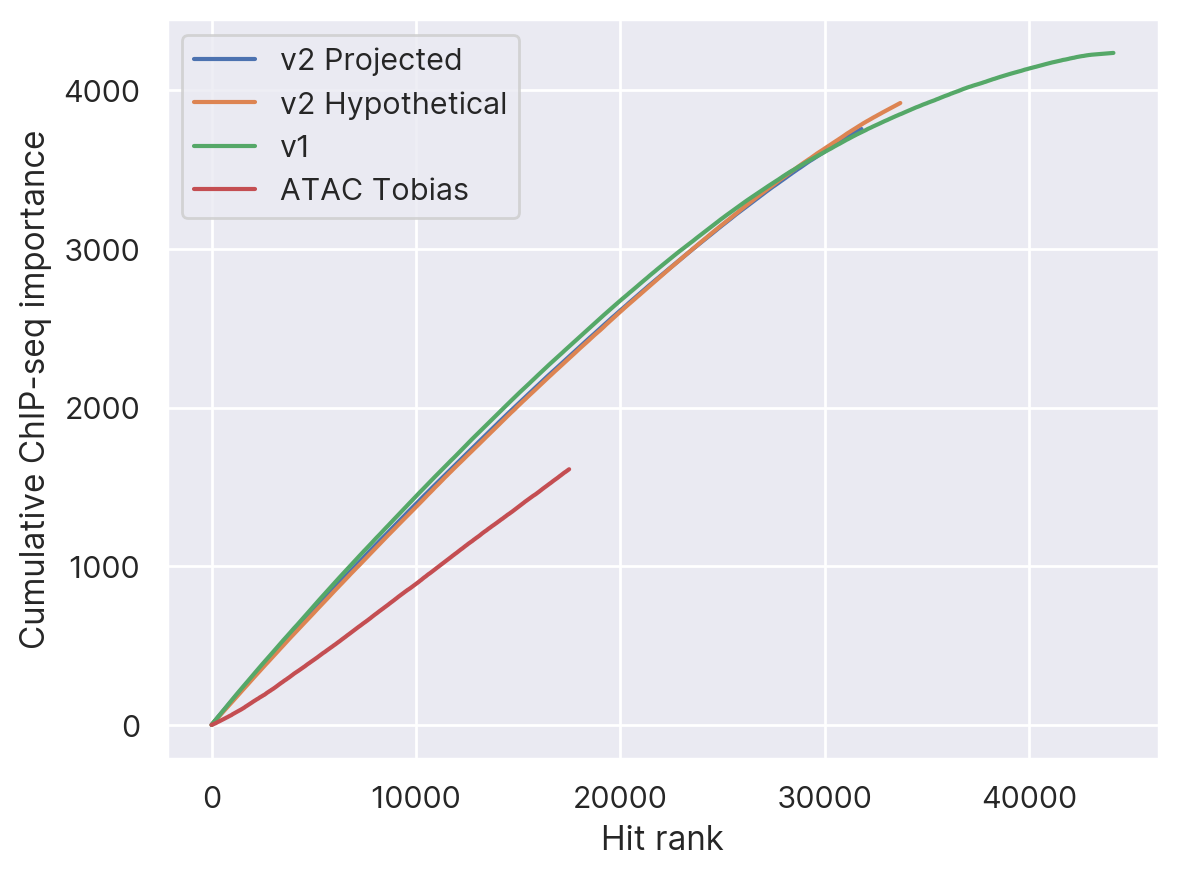

In [13]:
plot_scores(counts_dnase_proj_2, counts_dnase_hyp_2, counts_dnase, tobias_atac)

In [14]:
tf = "GATA"


params_tf = params[tf]

motif_hits_path_tobias =  motif_hits_path_tobias_template.format(tobias_motif_id=params_tf["tobias_motif_id"])
chip_seq_bw_path = chip_seq_bw_path_template.format(chip_enc=params_tf["chip_enc"])
chip_seq_bed_path = chip_seq_bed_path_template.format(chip_enc=params_tf["chip_enc"])

chip_seq_bw = pybw.open(chip_seq_bw_path)

tobias_motif_id = params_tf["tobias_motif_id"]
chip_enc = params_tf["chip_enc"]
dnase_motif_id = params_tf["dnase_motif_id"]
atac_motif_id = params_tf["atac_motif_id"]
v2_motif_id = params_tf["v2_motif_id"]

tobias_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+tobias_motif_id),"tobias_hits_in_peaks.bed")
find_hits_in_peaks(motif_hits_path_tobias, chip_seq_bed_path, tobias_hits_peaks)

# find_hits_in_peaks(atac_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+atac_motif_id), "atac_hits_in_peaks.bed")
# atac_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+atac_motif_id),"atac_hits_in_peaks.bed")

dnase_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"dnase_hits_in_peaks.bed")
find_hits_in_peaks(dnase_hits_path, chip_seq_bed_path, dnase_hits_peaks)

finemo_proj_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_proj_hits_in_peaks.bed")
find_hits_in_peaks(finemo_proj_hits_bed, chip_seq_bed_path, finemo_proj_hits_peaks)

finemo_hyp_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_hyp_hits_in_peaks.bed")
find_hits_in_peaks(finemo_hyp_hits_bed, chip_seq_bed_path, finemo_hyp_hits_peaks)

tobias_atac = fetch_footprint_scores_for_tobias(tobias_hits_peaks, chip_seq_bw, pfm_atac[atac_motif_id], genome)
tobias_atac.shape
#counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [atac_motif_id], chip_seq_bw, atac_bw, pfm_atac[atac_motif_id], genome)
# counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [dnase_motif_id], chip_seq_bw, atac_bw, pfm_dnase[dnase_motif_id], genome)


#counts_dnase = fetch_footprint_scores_for_chrombpnet(dnase_hits_path, [atac_motif_id], chip_seq_bw, dnase_bw, pfm_atac[atac_motif_id], genome)
counts_dnase = fetch_v1_scores_for_chrombpnet(dnase_hits_peaks, [dnase_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase_proj_2 = fetch_v2_scores_for_chrombpnet(finemo_proj_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)
counts_dnase_hyp_2 = fetch_v2_scores_for_chrombpnet(finemo_hyp_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)


bedtools intersect -a /mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/GATA3_GATA_1_GATA3_GATA_1/beds/GATA3_GATA_1_GATA3_GATA_1_K562_bound.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR257RKC_GATA3_GATA_1_GATA3_GATA_1/tobias_hits_in_peaks.bed


bedtools intersect -a /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/auxiliary/final.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR257RKC_0_0/dnase_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_proj.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR257RKC_0_0/finemo_proj_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_hyp.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_

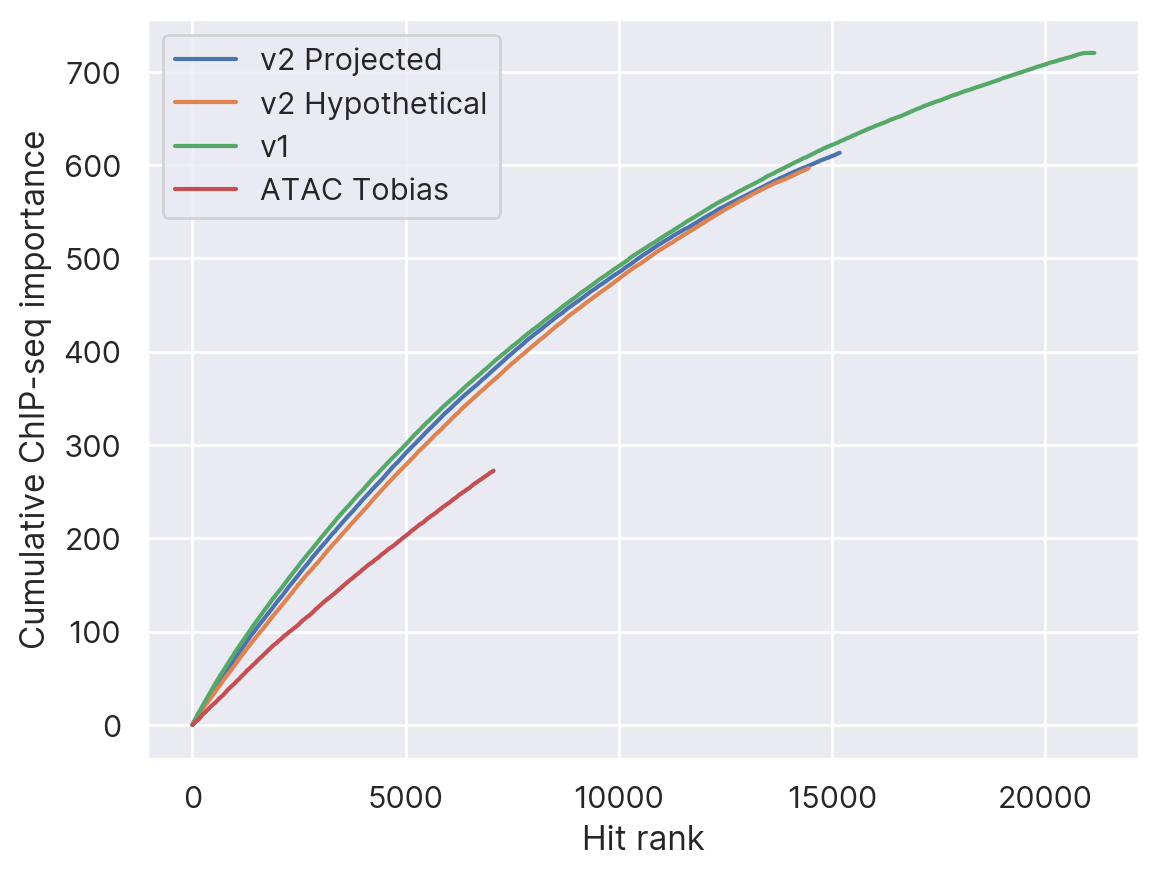

In [15]:
plot_scores(counts_dnase_proj_2, counts_dnase_hyp_2, counts_dnase, tobias_atac)

In [16]:
tf = "SP1"


params_tf = params[tf]

motif_hits_path_tobias =  motif_hits_path_tobias_template.format(tobias_motif_id=params_tf["tobias_motif_id"])
chip_seq_bw_path = chip_seq_bw_path_template.format(chip_enc=params_tf["chip_enc"])
chip_seq_bed_path = chip_seq_bed_path_template.format(chip_enc=params_tf["chip_enc"])

chip_seq_bw = pybw.open(chip_seq_bw_path)

tobias_motif_id = params_tf["tobias_motif_id"]
chip_enc = params_tf["chip_enc"]
dnase_motif_id = params_tf["dnase_motif_id"]
atac_motif_id = params_tf["atac_motif_id"]
v2_motif_id = params_tf["v2_motif_id"]

tobias_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+tobias_motif_id),"tobias_hits_in_peaks.bed")
find_hits_in_peaks(motif_hits_path_tobias, chip_seq_bed_path, tobias_hits_peaks)

# find_hits_in_peaks(atac_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+atac_motif_id), "atac_hits_in_peaks.bed")
# atac_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+atac_motif_id),"atac_hits_in_peaks.bed")

dnase_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"dnase_hits_in_peaks.bed")
find_hits_in_peaks(dnase_hits_path, chip_seq_bed_path, dnase_hits_peaks)

finemo_proj_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_proj_hits_in_peaks.bed")
find_hits_in_peaks(finemo_proj_hits_bed, chip_seq_bed_path, finemo_proj_hits_peaks)

finemo_hyp_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_hyp_hits_in_peaks.bed")
find_hits_in_peaks(finemo_hyp_hits_bed, chip_seq_bed_path, finemo_hyp_hits_peaks)

tobias_atac = fetch_footprint_scores_for_tobias(tobias_hits_peaks, chip_seq_bw, pfm_atac[atac_motif_id], genome)
tobias_atac.shape
#counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [atac_motif_id], chip_seq_bw, atac_bw, pfm_atac[atac_motif_id], genome)
# counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [dnase_motif_id], chip_seq_bw, atac_bw, pfm_dnase[dnase_motif_id], genome)


#counts_dnase = fetch_footprint_scores_for_chrombpnet(dnase_hits_path, [atac_motif_id], chip_seq_bw, dnase_bw, pfm_atac[atac_motif_id], genome)
counts_dnase = fetch_v1_scores_for_chrombpnet(dnase_hits_peaks, [dnase_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase_proj_2 = fetch_v2_scores_for_chrombpnet(finemo_proj_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)
counts_dnase_hyp_2 = fetch_v2_scores_for_chrombpnet(finemo_hyp_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)


bedtools intersect -a /mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C/beds/KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C_K562_bound.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C/tobias_hits_in_peaks.bed


bedtools intersect -a /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/auxiliary/final.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_0_2/dnase_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_proj.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_0_2/finemo_proj_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_hyp.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_

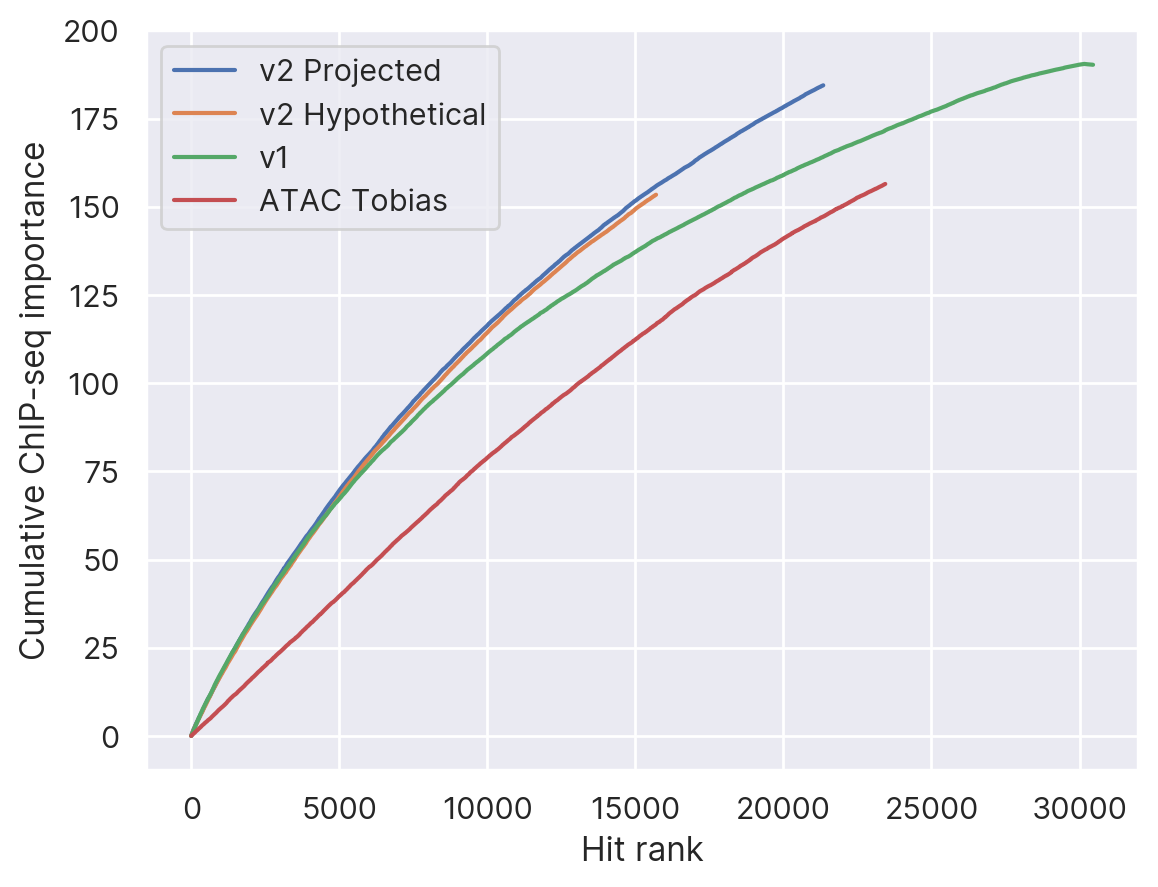

In [17]:
plot_scores(counts_dnase_proj_2, counts_dnase_hyp_2, counts_dnase, tobias_atac)

In [18]:
tf = "YY1"


params_tf = params[tf]

motif_hits_path_tobias =  motif_hits_path_tobias_template.format(tobias_motif_id=params_tf["tobias_motif_id"])
chip_seq_bw_path = chip_seq_bw_path_template.format(chip_enc=params_tf["chip_enc"])
chip_seq_bed_path = chip_seq_bed_path_template.format(chip_enc=params_tf["chip_enc"])

chip_seq_bw = pybw.open(chip_seq_bw_path)

tobias_motif_id = params_tf["tobias_motif_id"]
chip_enc = params_tf["chip_enc"]
dnase_motif_id = params_tf["dnase_motif_id"]
atac_motif_id = params_tf["atac_motif_id"]
v2_motif_id = params_tf["v2_motif_id"]

tobias_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+tobias_motif_id),"tobias_hits_in_peaks.bed")
find_hits_in_peaks(motif_hits_path_tobias, chip_seq_bed_path, tobias_hits_peaks)

# find_hits_in_peaks(atac_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+atac_motif_id), "atac_hits_in_peaks.bed")
# atac_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+atac_motif_id),"atac_hits_in_peaks.bed")

dnase_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"dnase_hits_in_peaks.bed")
find_hits_in_peaks(dnase_hits_path, chip_seq_bed_path, dnase_hits_peaks)

finemo_proj_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_proj_hits_in_peaks.bed")
find_hits_in_peaks(finemo_proj_hits_bed, chip_seq_bed_path, finemo_proj_hits_peaks)

finemo_hyp_hits_peaks = os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_hyp_hits_in_peaks.bed")
find_hits_in_peaks(finemo_hyp_hits_bed, chip_seq_bed_path, finemo_hyp_hits_peaks)

tobias_atac = fetch_footprint_scores_for_tobias(tobias_hits_peaks, chip_seq_bw, pfm_atac[atac_motif_id], genome)
tobias_atac.shape
#counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [atac_motif_id], chip_seq_bw, atac_bw, pfm_atac[atac_motif_id], genome)
# counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [dnase_motif_id], chip_seq_bw, atac_bw, pfm_dnase[dnase_motif_id], genome)


#counts_dnase = fetch_footprint_scores_for_chrombpnet(dnase_hits_path, [atac_motif_id], chip_seq_bw, dnase_bw, pfm_atac[atac_motif_id], genome)
counts_dnase = fetch_v1_scores_for_chrombpnet(dnase_hits_peaks, [dnase_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase_proj_2 = fetch_v2_scores_for_chrombpnet(finemo_proj_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)
counts_dnase_hyp_2 = fetch_v2_scores_for_chrombpnet(finemo_hyp_hits_peaks, [v2_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)


bedtools intersect -a /mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A/beds/TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A_K562_bound.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A/tobias_hits_in_peaks.bed


bedtools intersect -a /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/auxiliary/final.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_0_13/dnase_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_proj.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/ENCSR372IML_0_13/finemo_proj_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_tight/finemo_hits_hyp.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR372IML/peak

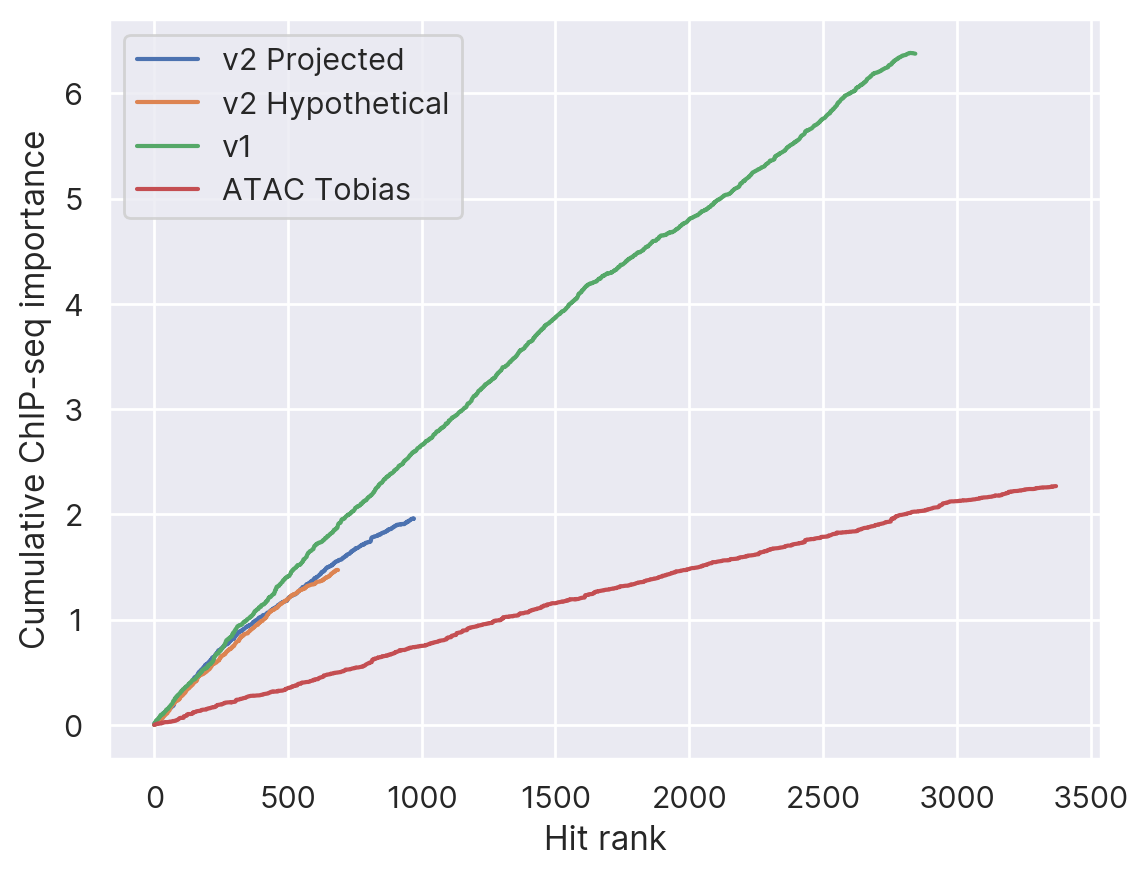

In [19]:
plot_scores(counts_dnase_proj_2, counts_dnase_hyp_2, counts_dnase, tobias_atac)